In [8]:
! git clone https://www.github.com/DS3001/PCA

Cloning into 'PCA'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 45 (delta 12), reused 14 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (45/45), 2.42 MiB | 7.28 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [2]:
import numpy as np
import pandas as pd
import pickle
from collections import Counter
from multiprocessing.pool import Pool
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')

In [4]:
tokens = df['Email Text'].str.split()
tokens.head()

,Email Text
0,"[re, :, 6, ., 1100, ,, disc, :, uniformitarian..."
1,"[the, other, side, of, *, galicismos, *, *, ga..."
2,"[re, :, equistar, deal, tickets, are, you, sti..."
3,"[Hello, I, am, your, hot, lil, horny, toy., I,..."
4,"[software, at, incredibly, low, prices, (, 86,..."


I would remove stop words such as "and" and "the" as well as numbers and special characters. Then I would mark the tokens for each email as predictors. Lastly, I'd run algorithms that searched for the appearance of tokens in emails to predict if they were spams.

In [10]:
with open('/content/PCA/05_PCA/all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)

from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

<Axes: >

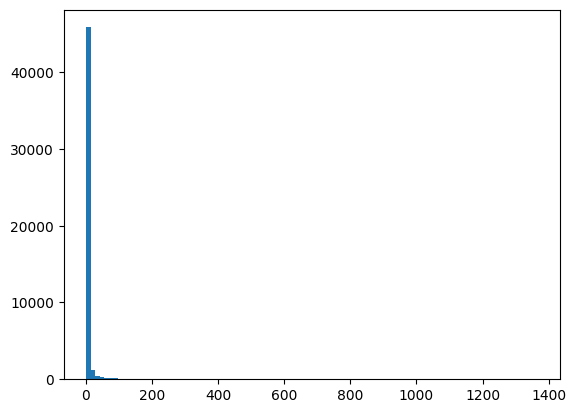

In [11]:
gdf = pd.DataFrame(token_freq,columns=['token','count'])
gdf['count'].hist(grid=False,bins=100)

Most tokens only appear once leading the graph to have a large tail. However, a minimum of one token does appear close to 1,400 times.

In [14]:
!pip install pyarrow
import pandas as pd

# Use pd.read_parquet instead of pd.read_csv for Parquet files
df = pd.read_parquet('/content/PCA/05_PCA/Phishing_clean.parquet')

In [15]:
y = df['Email Type']
X = df.drop('Email Type',axis=1)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=125)

In [17]:
lm_0 = LinearRegression(fit_intercept=False).fit(X_train,y_train)
y_hat_test_0 = lm_0.predict(X_test)
y_hat_train_0 = lm_0.predict(X_train)
print('train: ', r2_score(y_hat_train_0,y_train) )
print('test: ', r2_score(y_hat_test_0,y_test) )

train:  0.6210107280960204
test:  -0.00026838432670373


The R^2 on the training set is 0.62 and on the testing set it's 0.00.

In [18]:
rdf = pd.DataFrame({'variable':lm_0.feature_names_in_ , 'value':lm_0.coef_})
rdf['abs'] = np.abs(rdf['value'])
rdf.sort_values('abs',ascending=False)

,variable,value,abs
710,1997,-1.415784e+13,1.415784e+13
421,1995,1.158467e+13,1.158467e+13
1133,"19,",-1.025713e+13,1.025713e+13
340,2005,-9.773947e+12,9.773947e+12
1146,-0400,-8.062341e+12,8.062341e+12
...,...,...,...
1399,union,2.822876e-04,2.822876e-04
565,east,-2.746582e-04,2.746582e-04
2268,ravages,-1.068115e-04,1.068115e-04
457,due,-6.484985e-05,6.484985e-05


Numbers, specifically years, have the largest coefficients in absolute value and most strongly influence predictions.

<Axes: >

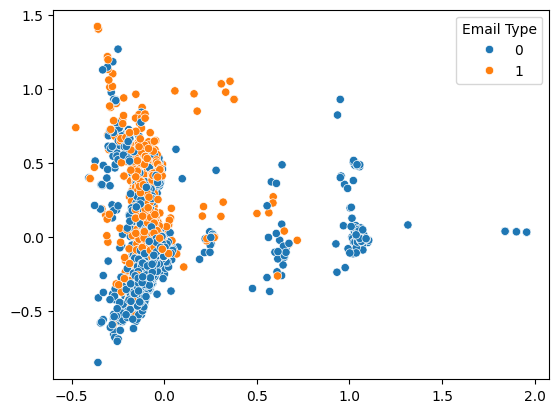

In [19]:
reduction = PCA(n_components=2).fit(X_train)
Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)
sns.scatterplot(x=Z_test[:,0],y=Z_test[:,1],hue=y_test)

The orange points are the scams. They tend to have a low first component and a high second component.

In [20]:
reduction = PCA(n_components=2610).fit(X_train)
Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)

In [21]:
lm_k = LinearRegression().fit(Z_train,y_train)
y_hat_test = lm_k.predict(Z_test)
y_hat_train = lm_k.predict(Z_train)

In [22]:
print('Train r2: ', r2_score(y_hat_train,y_train) )
print('Test r2: ', r2_score(y_hat_test,y_test) )

Train r2:  0.692897536096375
Test r2:  0.5873905973217184


This performance is much better than the linear regression. The linear regression had an R^2 of 0.00.

The advantage in using principal components to run this high-dimensional regression is that it simplifies computational capacity, eliminates the possibility of multicolinearity, and reduces the number of predictors. The drawbacks are that we lose interpretability and risk losing some data.